# CNN training

In [1]:
import os
import re
import random
import datetime
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

import PIL
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from __future__ import print_function
import keras
import keras.preprocessing
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Tensorflow version 2.2.0


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functions

In [3]:
def fileToList(file_name):
    result_list = [] 
    fp = open(file_name)
    for row in fp:
        row = row.strip()
        row = row.replace("\"","")
        row = re.split('\t',row)
        #row = re.split(r'[;,\s]\s*', row)
        result_list.append(row)
    fp.close()  
    return result_list 

In [4]:
def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))
    
    return model

In [5]:
def showImg(img_data):
    if type(img_data) is list:
        image = tf.keras.preprocessing.image.load_img(img_data)
        plt.imshow(image)
    if type(img_data) is np.ndarray:
        image = tf.keras.preprocessing.image.array_to_img(img_data)
        plt.imshow(image)
        
        

In [6]:
def resizeCropImg(img_file, target_width, target_height):
    image = tf.keras.preprocessing.image.load_img(img_file)
    width, height = image.size
    left   = width*0.13
    top    = height*0.13
    right  = width*0.87
    bottom = height*0.87
    image = image.crop((left, top, right, bottom))
    image = image.resize((target_width, target_height))
    return image

In [7]:
def loadImgs(cnv_list, img_width, img_height):
    cnv_np = np.zeros((len(cnv_list), img_width, img_height, 3))
    for index, each_cnv in enumerate(cnv_list):
        if index % 1000 == 1:
            time_stamp = datetime.datetime.now()
            time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
            print("[%s] Processing %d ..."%(time_str, index))
        cnv_img = resizeCropImg(each_cnv, img_width, img_height)
        cnv_np[index] = tf.keras.preprocessing.image.img_to_array(cnv_img)
    time_stamp = datetime.datetime.now()
    time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
    print("[%s] Done %d."%(time_str, index))
    return cnv_np

# Processing

In [8]:
img_width, img_height = 224, 224

In [ ]:
## For all deletions, including common and rare
true_del_file = '/home/rt2776/cnv_espresso/images/true_del_entire_path.list'
false_del_file = '/home/rt2776/cnv_espresso/images/false_del_entire_path.list'

In [9]:
## For rare deletions
true_del_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_del.list'
false_del_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_del.list'

In [30]:
## For rare duplications
true_dup_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_dup.list'
false_dup_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_dup.list'

In [53]:
## For splited rare deletions
true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_del_splits.list'
false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_del_splits.list'

In [9]:
## For splited rare duplications
true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_dup_splits.list'
false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_dup_splits.list'

### Loading cnv image file paths to list

In [79]:
true_list = [each_file[0] for each_file in fileToList(true_file)]
false_list = [each_file[0] for each_file in fileToList(false_file)]
len(true_list), len(false_list)

(64914, 7982)

### Loading images from list to numpy array

In [80]:
false_img_np = loadImgs(false_list, img_width, img_height)
false_img_np.shape

[2021.01.15-21:41:26] Processing 1 ...
[2021.01.15-21:42:55] Processing 1001 ...
[2021.01.15-21:44:34] Processing 2001 ...
[2021.01.15-21:46:11] Processing 3001 ...
[2021.01.15-21:47:47] Processing 4001 ...
[2021.01.15-21:49:19] Processing 5001 ...
[2021.01.15-21:50:50] Processing 6001 ...
[2021.01.15-21:52:24] Processing 7001 ...
[2021.01.15-21:53:57] Done 7981.


(7982, 224, 224, 3)

In [81]:
true_img_np = loadImgs(true_list, img_width, img_height)
true_img_np.shape

[2021.01.15-21:53:58] Processing 1 ...
[2021.01.15-21:55:29] Processing 1001 ...
[2021.01.15-21:56:51] Processing 2001 ...
[2021.01.15-21:58:13] Processing 3001 ...
[2021.01.15-21:59:34] Processing 4001 ...
[2021.01.15-22:00:58] Processing 5001 ...
[2021.01.15-22:02:20] Processing 6001 ...
[2021.01.15-22:03:35] Processing 7001 ...
[2021.01.15-22:04:53] Processing 8001 ...
[2021.01.15-22:06:15] Processing 9001 ...
[2021.01.15-22:07:38] Processing 10001 ...
[2021.01.15-22:09:00] Processing 11001 ...
[2021.01.15-22:10:22] Processing 12001 ...
[2021.01.15-22:11:44] Processing 13001 ...
[2021.01.15-22:13:13] Processing 14001 ...
[2021.01.15-22:14:37] Processing 15001 ...
[2021.01.15-22:16:02] Processing 16001 ...
[2021.01.15-22:17:29] Processing 17001 ...
[2021.01.15-22:18:57] Processing 18001 ...
[2021.01.15-22:20:25] Processing 19001 ...
[2021.01.15-22:21:48] Processing 20001 ...
[2021.01.15-22:23:15] Processing 21001 ...
[2021.01.15-22:24:38] Processing 22001 ...
[2021.01.15-22:26:03] Pr

(64914, 224, 224, 3)

### Generage labels

In [82]:
true_label = [1 for i in range(0,len(true_img_np))]
false_label = [0 for i in range(0,len(false_img_np))]
print(true_label[0:5], false_label[0:5])
print(len(true_label), len(false_label))

[1, 1, 1, 1, 1] [0, 0, 0, 0, 0]
64914 7982


### Combine and shuffle true and false data

In [83]:
combined_img = np.vstack((true_img_np, false_img_np))
combined_label = true_label + false_label

In [84]:
tmp = list(zip(combined_img, combined_label))
random.shuffle(tmp)
combined_img, combined_label = zip(*tmp)
combined_img_np = np.asarray(combined_img)

### Backup or restore

In [85]:
np.save('/home/rt2776/cnv_espresso/images_rare/rare_dup_splits_label', combined_label)
np.save('/home/rt2776/cnv_espresso/images_rare/rare_dup_splits_img_np', combined_img_np)

In [10]:
combined_label = np.load('/home/rt2776/cnv_espresso/images_rare/rare_dup_splits_label.npy')
combined_img_np = np.load('/home/rt2776/cnv_espresso/images_rare/rare_dup_splits_img_np.npy')

In [11]:
combined_img_np.shape

(72896, 224, 224, 3)

### Split dataset into training(80%) and testing(20%) dataset

In [12]:
train_img, test_img, train_label, test_label = train_test_split(combined_img_np,combined_label,test_size=0.2,random_state=0)

In [13]:
train_img.shape, test_img.shape

((58316, 224, 224, 3), (14580, 224, 224, 3))

In [14]:
len(train_label), len(test_label)

(58316, 14580)

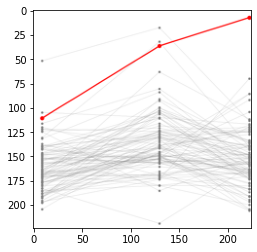

In [15]:
showImg(train_img[1])

### Normalization

In [16]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = train_img.shape[1:]
input_shape = (nRows, nCols, nDims)

In [17]:
# Change to float datatype
train_img = train_img.astype('float32')
test_img = test_img.astype('float32')

# Scale the data to lie between 0 to 1
train_img /= 255
test_img /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_label)
test_labels_one_hot = to_categorical(test_label)

In [18]:
# Find the unique numbers from the train labels
classes = np.unique(train_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


1


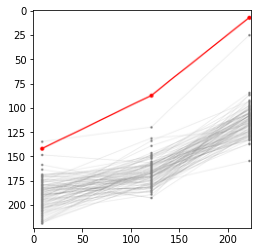

In [19]:
item = random.randint(0,len(train_label))
print(train_label[item])
showImg(train_img[item])

### Train deep nerual network model

In [22]:
model1 = createModel()
batch_size = 40
epochs = 50
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model1.fit(train_img, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_data=(test_img, test_labels_one_hot), callbacks=[es, mc])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)       

In [23]:
model1.evaluate(test_img, test_labels_one_hot)

456/456 [==============================] - 19s 41ms/step - loss: 0.3559 - accuracy: 0.8929


[0.35592806339263916, 0.8928669691085815]

Text(0.5, 1.0, 'Loss Curves')

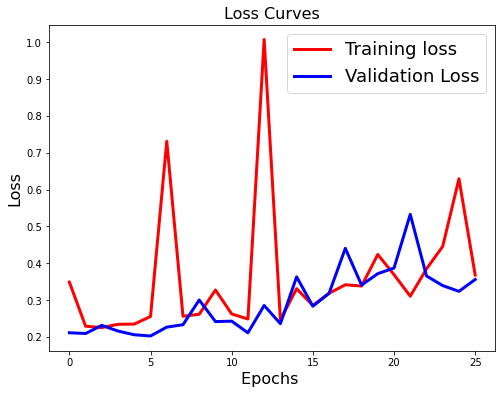

In [24]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

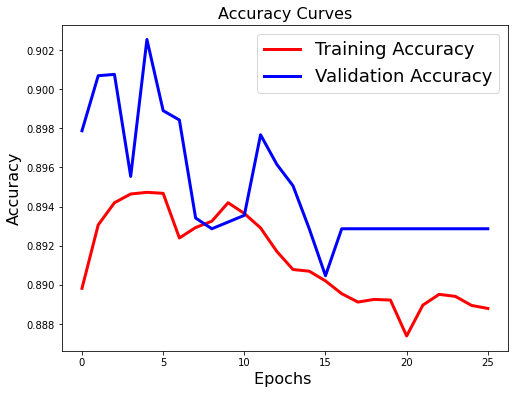

In [25]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

## Reference:
- load image: https://keras.io/api/preprocessing/image/#load_img-function
- Model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- https://zhuanlan.zhihu.com/p/51889181